<a href="https://colab.research.google.com/github/BelloBer/Landslide-Detection/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Starting Fixed Landslide Detection Pipeline...
TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading training data...
Total training samples: 7147
Class distribution:
label
0    5892
1    1255
Name: count, dtype: int64
Training samples: 5717
Validation samples: 1430
Testing data generator...
Batch shape: (16, 128, 128, 12), (16, 1)
Creating enhanced multi-spectral model...
Class weights: {0: np.float64(0.6065003394433129), 1: np.float64(2.847410358565737)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (GetItem)           │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 128, 128,  │          0 │ get_item[0][0]    │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 128, 128,  │          0 │ get_item_1[0][0]  │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,184 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      2,336 │ cast_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ concatenate[0][0

 Total params: 359,617 (1.37 MB)

 Trainable params: 356,801 (1.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

None
Starting training...
Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6101 - loss: 0.7080 - precision: 0.2754 - recall: 0.7459
Epoch 1: val_accuracy improved from -inf to 0.82448, saving model to best_landslide_model_fixed.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3524s 10s/step - accuracy: 0.6102 - loss: 0.7078 - precision: 0.2755 - recall: 0.7460 - val_accuracy: 0.8245 - val_loss: 0.4974 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7135 - loss: 0.5385 - precision: 0.3732 - recall: 0.8346
Epoch 2: val_accuracy did not improve from 0.82448
358/358 ━━━━━━━━━━━━━━━━━━━━ 257s 584ms/step - accuracy: 0.7136 - loss: 0.5385 - precision: 0.3732 - recall: 0.8346 - val_accuracy: 0.8224 - val_loss: 0.6230 - val_precision: 0.3846 - val_recall: 0.0199 - learning_rate: 1.0000e-04
Epoch 3/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7448 - loss: 0.5065 - precision: 0.3824 - recall: 0.8012
Epoch 3: val_accuracy improved from 0.82448 to 0.86014, saving model to best_landslide_model_fixed.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 201s 562ms/step - accuracy: 0.7449 - loss: 0.5065 - precision: 0.3825 - recall: 0.8012 - val_accuracy: 0.8601 - val_loss: 0.4208 - val_precision: 0.8923 - val_recall: 0.2311 - learning_rate: 1.0000e-04
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7854 - loss: 0.4457 - precision: 0.4323 - recall: 0.8319
Epoch 4: val_accuracy improved from 0.86014 to 0.87972, saving model to best_landslide_model_fixed.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 197s 550ms/step - accuracy: 0.7854 - loss: 0.4457 - precision: 0.4323 - recall: 0.8319 - val_accuracy: 0.8797 - val_loss: 0.3124 - val_precision: 0.7687 - val_recall: 0.4502 - learning_rate: 1.0000e-04
Epoch 5/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8014 - loss: 0.4606 - precision: 0.4799 - recall: 0.8215
Epoch 5: val_accuracy did not improve from 0.87972
358/358 ━━━━━━━━━━━━━━━━━━━━ 199s 555ms/step - accuracy: 0.8015 - loss: 0.4605 - precision: 0.4799 - recall: 0.8215 - val_accuracy: 0.8392 - val_loss: 0.5373 - val_precision: 0.9565 - val_recall: 0.0876 - learning_rate: 1.0000e-04
Epoch 6/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8248 - loss: 0.4109 - precision: 0.5074 - recall: 0.8305
Epoch 6: val_accuracy did not improve from 0.87972
358/358 ━━━━━━━━━━━━━━━━━━━━ 198s 553ms/step - accuracy: 0.8248 - loss: 0.4109 - precision: 0.5074 - recall: 0.8305 - val_accuracy: 0.8797 - val_loss: 0.3098 - val_precision: 0.9247 - 

358/358 ━━━━━━━━━━━━━━━━━━━━ 199s 556ms/step - accuracy: 0.8218 - loss: 0.4103 - precision: 0.4911 - recall: 0.8200 - val_accuracy: 0.8804 - val_loss: 0.3662 - val_precision: 0.8448 - val_recall: 0.3904 - learning_rate: 1.0000e-04
Epoch 8/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8427 - loss: 0.3567 - precision: 0.5275 - recall: 0.8586
Epoch 8: val_accuracy did not improve from 0.88042
358/358 ━━━━━━━━━━━━━━━━━━━━ 196s 548ms/step - accuracy: 0.8427 - loss: 0.3567 - precision: 0.5275 - recall: 0.8585 - val_accuracy: 0.8462 - val_loss: 0.5610 - val_precision: 0.9429 - val_recall: 0.1315 - learning_rate: 1.0000e-04
Epoch 9/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8593 - loss: 0.3402 - precision: 0.5627 - recall: 0.8668
Epoch 9: val_accuracy did not improve from 0.88042
358/358 ━━━━━━━━━━━━━━━━━━━━ 208s 582ms/step - accuracy: 0.8593 - loss: 0.3402 - precision: 0.5627 - recall: 0.8668 - val_accuracy: 0.8797 - val_loss: 0.3114 - val_precision: 0.9438 - 

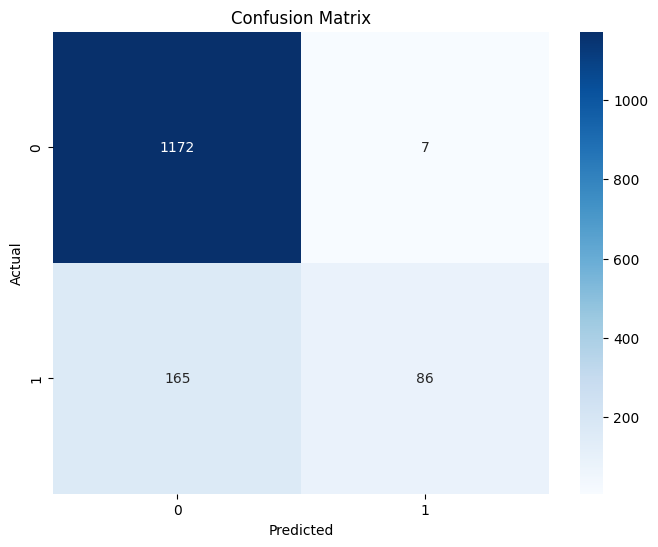


Pipeline completed successfully!
Model saved as: best_landslide_model_fixed.h5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Landslide Detection Challenge - Fixed Version with Multi-Channel Support

"""
This fixed version addresses the channel number issue and other improvements:
1. Fixed augmentation for 12-channel images
2. Better error handling and validation
3. Improved memory management
4. More robust data preprocessing
5. Enhanced model architecture for multi-spectral data
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                   BatchNormalization, Input, GlobalAveragePooling2D,
                                   SeparableConv2D, Activation, Add, Concatenate)
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping,
                                      ReduceLROnPlateau, TensorBoard)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Enable mixed precision for better performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# =============================================================================
# CONFIGURATION
# =============================================================================

CONFIG = {
    'train_data_path': '/content/drive/My Drive/train_data/',
    'test_data_path': '/content/drive/My Drive/test_data/',
    'train_csv': '/content/drive/My Drive/train_data/Train.csv',
    'test_csv': '/content/drive/My Drive/test_data/Test.csv',
    'batch_size': 16,
    'image_size': (128, 128),
    'n_bands': 12,
    'epochs': 100,
    'validation_split': 0.2,
    'learning_rate': 1e-4,
    'patience': 15
}

# =============================================================================
# ENHANCED IMAGE PROCESSING FOR MULTI-CHANNEL DATA
# =============================================================================

class MultiChannelImageProcessor:
    """Enhanced image preprocessing specifically designed for 12-channel satellite data"""

    @staticmethod
    def normalize_optical_bands(img, bands=[0, 1, 2, 3]):
        """Normalize optical bands (0-3) using robust percentile clipping"""
        img_norm = img.copy()
        for band in bands:
            if band < img.shape[2]:
                data = img[:, :, band]
                # Use robust percentile clipping
                p2, p98 = np.percentile(data[data > 0], (2, 98)) if np.any(data > 0) else (0, 1)
                data = np.clip(data, p2, p98)
                # Robust min-max normalization
                data_range = p98 - p2
                if data_range > 0:
                    img_norm[:, :, band] = (data - p2) / data_range
                else:
                    img_norm[:, :, band] = 0
        return img_norm

    @staticmethod
    def normalize_sar_bands(img, bands=list(range(4, 12))):
        """Enhanced SAR band normalization with better handling of complex values"""
        img_norm = img.copy()
        for band in bands:
            if band < img.shape[2]:
                sar_data = img[:, :, band]

                # Handle different SAR data formats
                if np.iscomplexobj(sar_data):
                    # Complex SAR data - convert to intensity
                    sar_power = np.abs(sar_data) ** 2
                elif np.any(sar_data < 0):
                    # Signed amplitude data
                    sar_power = np.abs(sar_data) ** 2
                else:
                    # Positive intensity/power data
                    sar_power = np.abs(sar_data)

                # Convert to dB with proper epsilon handling
                epsilon = 1e-10
                sar_power = np.maximum(sar_power, epsilon)
                sar_db = 10 * np.log10(sar_power)

                # Robust normalization
                valid_mask = np.isfinite(sar_db)
                if np.any(valid_mask):
                    p1, p99 = np.percentile(sar_db[valid_mask], (1, 99))
                    sar_db = np.clip(sar_db, p1, p99)
                    sar_range = p99 - p1
                    if sar_range > 0:
                        img_norm[:, :, band] = (sar_db - p1) / sar_range
                    else:
                        img_norm[:, :, band] = 0
                else:
                    img_norm[:, :, band] = 0

        return img_norm

    @staticmethod
    def load_and_preprocess_image(image_path, target_size=(128, 128)):
        """Load and preprocess image with comprehensive error handling"""
        try:
            # Load the numpy array
            img = np.load(image_path)

            # Ensure float32 dtype
            img = img.astype(np.float32)

            # Handle different input shapes
            if len(img.shape) == 2:
                # Grayscale image - expand to 12 channels by repeating
                img = np.expand_dims(img, axis=-1)
                img = np.repeat(img, 12, axis=-1)
            elif len(img.shape) == 3:
                # Multi-channel image
                if img.shape[2] < 12:
                    # Pad with zeros if fewer than 12 channels
                    padding = np.zeros((*img.shape[:2], 12 - img.shape[2]), dtype=np.float32)
                    img = np.concatenate([img, padding], axis=-1)
                elif img.shape[2] > 12:
                    # Truncate if more than 12 channels
                    img = img[:, :, :12]

            # Resize if necessary
            if img.shape[:2] != target_size:
                # Simple resize using numpy (channel-wise)
                from scipy.ndimage import zoom
                zoom_factors = (target_size[0] / img.shape[0],
                               target_size[1] / img.shape[1], 1)
                img = zoom(img, zoom_factors, order=1)

            # Normalize optical bands (0-3)
            img = MultiChannelImageProcessor.normalize_optical_bands(img)

            # Normalize SAR bands (4-11)
            img = MultiChannelImageProcessor.normalize_sar_bands(img)

            # Final cleanup: handle any remaining invalid values
            img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)

            # Ensure values are in [0, 1] range
            img = np.clip(img, 0.0, 1.0)

            return img

        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return zero array as fallback
            return np.zeros((*target_size, 12), dtype=np.float32)

# =============================================================================
# FIXED DATA GENERATOR WITH PROPER MULTI-CHANNEL AUGMENTATION
# =============================================================================

class FixedLandslideDataGenerator(Sequence):
    """Fixed data generator with proper multi-channel augmentation support"""

    def __init__(self, df, data_path, batch_size=16, shuffle=True,
                 augment=False, validation=False):
        self.df = df.reset_index(drop=True)
        self.data_path = data_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.validation = validation
        self.indices = np.arange(len(self.df))
        self.processor = MultiChannelImageProcessor()

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.zeros((len(batch_indices), 128, 128, 12), dtype=np.float32)
        batch_y = np.zeros((len(batch_indices), 1), dtype=np.float32)

        for i, data_idx in enumerate(batch_indices):
            try:
                # Load image
                image_id = self.df.iloc[data_idx]['ID']
                image_path = os.path.join(self.data_path, f"{image_id}.npy")
                img = self.processor.load_and_preprocess_image(image_path)

                # Apply augmentation if enabled (fixed for multi-channel)
                if self.augment and not self.validation:
                    img = self._augment_multichannel_image(img)

                batch_x[i] = img
                batch_y[i] = self.df.iloc[data_idx]['label']

            except Exception as e:
                print(f"Error processing sample {data_idx}: {e}")
                # Use zero array as fallback
                batch_x[i] = np.zeros((128, 128, 12), dtype=np.float32)
                batch_y[i] = 0

        return batch_x, batch_y

    def _augment_multichannel_image(self, img):
        """Apply augmentations that work with multi-channel images"""
        # All augmentations use numpy operations that work with any number of channels

        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.fliplr(img)

        # Random vertical flip
        if np.random.random() > 0.5:
            img = np.flipud(img)

        # Random rotation (90, 180, 270 degrees)
        k = np.random.randint(0, 4)
        if k > 0:
            img = np.rot90(img, k, axes=(0, 1))  # Specify axes for multi-channel

        # Random brightness adjustment (only for optical bands)
        if np.random.random() > 0.7:
            brightness_factor = np.random.uniform(0.8, 1.2)
            img[:, :, :4] *= brightness_factor  # Apply only to optical bands
            img = np.clip(img, 0.0, 1.0)

        # Random noise addition (small amount)
        if np.random.random() > 0.8:
            noise = np.random.normal(0, 0.01, img.shape).astype(np.float32)
            img = np.clip(img + noise, 0.0, 1.0)

        return img

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# =============================================================================
# ENHANCED MODEL ARCHITECTURE FOR MULTI-SPECTRAL DATA
# =============================================================================

def create_multispectral_model(input_shape=(128, 128, 12), num_classes=1):
    """Create a model specifically designed for multi-spectral satellite data"""

    inputs = Input(shape=input_shape)

    # Separate processing for optical and SAR bands
    optical_bands = inputs[:, :, :, :4]  # First 4 channels (optical)
    sar_bands = inputs[:, :, :, 4:]      # Last 8 channels (SAR)

    # Optical branch
    opt_x = Conv2D(32, (3, 3), padding='same', activation='relu')(optical_bands)
    opt_x = BatchNormalization()(opt_x)
    opt_x = Conv2D(32, (3, 3), padding='same', activation='relu')(opt_x)
    opt_x = BatchNormalization()(opt_x)
    opt_x = MaxPooling2D((2, 2))(opt_x)

    # SAR branch
    sar_x = Conv2D(32, (3, 3), padding='same', activation='relu')(sar_bands)
    sar_x = BatchNormalization()(sar_x)
    sar_x = Conv2D(32, (3, 3), padding='same', activation='relu')(sar_x)
    sar_x = BatchNormalization()(sar_x)
    sar_x = MaxPooling2D((2, 2))(sar_x)

    # Combine branches
    x = Concatenate()([opt_x, sar_x])
    x = Dropout(0.25)(x)

    # Shared processing layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    x = SeparableConv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    # Classification head
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer (use float32 for final layer due to mixed precision)
    outputs = Dense(num_classes, activation='sigmoid', dtype='float32')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# =============================================================================
# IMPROVED TRAINING PIPELINE WITH BETTER ERROR HANDLING
# =============================================================================

def robust_training_pipeline():
    """Robust training pipeline with comprehensive error handling"""

    try:
        # Load and validate data
        print("Loading training data...")
        if not os.path.exists(CONFIG['train_csv']):
            raise FileNotFoundError(f"Training CSV not found: {CONFIG['train_csv']}")

        train_df = pd.read_csv(CONFIG['train_csv'])

        # Validate data
        required_columns = ['ID', 'label']
        if not all(col in train_df.columns for col in required_columns):
            raise ValueError(f"Missing required columns. Expected: {required_columns}")

        print(f"Total training samples: {len(train_df)}")
        print(f"Class distribution:\n{train_df['label'].value_counts()}")

        # Check for data path
        if not os.path.exists(CONFIG['train_data_path']):
            raise FileNotFoundError(f"Training data path not found: {CONFIG['train_data_path']}")

        # Create stratified split
        train_data, val_data = train_test_split(
            train_df,
            test_size=CONFIG['validation_split'],
            random_state=42,
            stratify=train_df['label']
        )

        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")

        # Create data generators with error handling
        train_gen = FixedLandslideDataGenerator(
            train_data,
            CONFIG['train_data_path'],
            batch_size=CONFIG['batch_size'],
            shuffle=True,
            augment=True
        )

        val_gen = FixedLandslideDataGenerator(
            val_data,
            CONFIG['train_data_path'],
            batch_size=CONFIG['batch_size'],
            shuffle=False,
            augment=False,
            validation=True
        )

        # Test data generator
        print("Testing data generator...")
        test_batch = train_gen[0]
        print(f"Batch shape: {test_batch[0].shape}, {test_batch[1].shape}")

        # Create model
        print("Creating enhanced multi-spectral model...")
        model = create_multispectral_model()

        # Compile with class weight balancing
        class_counts = train_df['label'].value_counts().sort_index()
        total_samples = len(train_df)
        class_weight = {
            0: total_samples / (2 * class_counts[0]),
            1: total_samples / (2 * class_counts[1])
        }
        print(f"Class weights: {class_weight}")

        # Use a simpler optimizer for stability
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=CONFIG['learning_rate'],
            clipnorm=1.0
        )

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        print(model.summary())

        # Enhanced callbacks
        callbacks = [
            ModelCheckpoint(
                'best_landslide_model_fixed.h5',
                monitor='val_accuracy',
                mode='max',
                save_best_only=True,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=CONFIG['patience'],
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                verbose=1
            )
        ]

        # Train model
        print("Starting training...")
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=CONFIG['epochs'],
            callbacks=callbacks,
            class_weight=class_weight,
            verbose=1
        )

        return model, history, val_gen

    except Exception as e:
        print(f"Error in training pipeline: {e}")
        print("Please check your data paths and file formats.")
        raise

# =============================================================================
# SIMPLE BUT EFFECTIVE EVALUATION
# =============================================================================

def evaluate_model(model, val_gen):
    """Simple but comprehensive model evaluation"""

    print("Evaluating model...")

    # Generate predictions
    y_true = []
    y_pred_proba = []

    for i in range(len(val_gen)):
        try:
            batch_x, batch_y = val_gen[i]
            batch_pred = model.predict(batch_x, verbose=0)

            y_true.extend(batch_y.flatten())
            y_pred_proba.extend(batch_pred.flatten())
        except Exception as e:
            print(f"Error in batch {i}: {e}")
            continue

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    try:
        auc_score = roc_auc_score(y_true, y_pred_proba)
        print(f"AUC Score: {auc_score:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    except Exception as e:
        print(f"Error in evaluation: {e}")

    return y_true, y_pred, y_pred_proba

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""
    print("Starting Fixed Landslide Detection Pipeline...")
    print("="*60)

    try:
        # Check TensorFlow setup
        print(f"TensorFlow version: {tf.__version__}")
        print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

        # Run training pipeline
        model, history, val_gen = robust_training_pipeline()

        # Evaluate model
        y_true, y_pred, y_pred_proba = evaluate_model(model, val_gen)

        print("\nPipeline completed successfully!")
        print("Model saved as: best_landslide_model_fixed.h5")

    except Exception as e:
        print(f"Pipeline failed with error: {e}")
        print("\nTroubleshooting tips:")
        print("1. Check that all file paths in CONFIG are correct")
        print("2. Ensure your data files exist and are readable")
        print("3. Verify you have sufficient memory for the batch size")
        print("4. Try reducing batch_size if you encounter memory errors")

if __name__ == "__main__":
    main()